# Find momentum resolution

In [3]:
file_name_au = "nts.mu2e.CeEndpointOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.001210_00000339.root"

In [4]:
from pyutils.pyprocess import Processor
processor = Processor(use_remote=True, location="disk")

[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=1


In [175]:
branches={
    "trk" : ["trk.pdg"],
    "trkfit" : ["trksegs"],
    "trkmc": ["trkmcsim"]
}
data = processor.process_data(file_name_au, branches=branches)

[pyprocess] ✅ Completed process on nts.mu2e.CeEndpointOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.001210_00000339.root


In [176]:
from pyutils.pyprint import Print
Print(verbose=False).print_n_events(data)

[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[pyprint] ⭐️ Printing 1 event(s)...

-------------------------------------------------------------------------------------
trk.trk.pdg: [11, -11, 13, -13]
trkfit.trksegs.mom.fCoordinates.fX: [[69.6, 96.3, 88.2, 100, 103, 91.3, ..., 64.2, 18.8, 33.6, 36.9, -80], ...]
trkfit.trksegs.mom.fCoordinates.fY: [[-69.4, 19.9, 43.1, 19.7, 16.9, 45.2, ..., -61.3, 86.6, -79.7, 76, 21.4], ...]
trkfit.trksegs.mom.fCoordinates.fZ: [[-37.6, -37.4, -37.5, -24.2, 11.6, 23.4, ..., 54.5, 54.5, 57.6, 60, 61.5], ...]
trkfit.trksegs.pos.fCoordinates.fX: [[-264, -49.3, 5.7, -48.2, -51.5, 10.5, ..., -279, 161, -372, 128, -56.6], ...]
trkfit.trksegs.pos.fCoordinates.fY: [[103, 38.7, 57.5, 37.3, 36.1, 57, ..., 54.4, 110, 253, 206, 193, 588], ...]
trkfit.trksegs.pos.fCoordinates.fZ: [[-3.9e+03, -3.99e+03, -4.01e+03, ..., -1.63e+03, 10.1, 1.64e+03], ..., [...]]
trkfit.trksegs.time: [[1.52e+03, 1.52e+03, 1.52e+03, ..., 1.57e+03, 1.58e+03, 1.59e+03

In [214]:
from pyutils.pyselect import Select
from pyutils.pyvector import Vector
from pyutils.pylogger import Logger
from pyutils.pyprint import Print
import awkward as ak
class Test:
    def __init__(self):
        
        # self.analyse = analyse
        # Get attributes from analyse instance
        # self.thresholds = analyse.thresholds
        self.selector = Select() # selector
        self.vector = Vector() # analyse.vector
        self.verbosity = 2
        self.printer = Print()

        # Seperate logger
        self.logger = Logger(
            print_prefix="[Test]",
            verbosity=self.verbosity
        )
        
    def _prepare_track_data(self, data):
        """
        Loose cuts

        We have to select 
        - Electron fits at the tracker entrance
        - MC track parents 

        and everything needs to align! Must ensure that MC truth 
        
        Returns:
            tuple: (trk, trkfit, trkmcsim)
        """
        trk = data["trk"]
        trkfit = data["trkfit"]
        trkmc = data["trkmc"] 
        
        # Select electron tracks
        is_reco_electron = self.selector.is_electron(data["trk"])

        # Select tracker front
        at_trk_front = self.selector.select_surface(trkfit, surface_name="TT_Front")
        has_trk_front = ak.any(at_trk_front, axis=-1)

        # Apply trksegs-level selection
        # This must come first!
        trkfit = trkfit[at_trk_front]

        # Construct combined trk reco mask 
        trk_reco_mask = is_reco_electron & has_trk_front 

        # Apply trk-level selection 
        trk = trk[trk_reco_mask]
        trkfit = trkfit[trk_reco_mask]
        trkmc = trkmc[trk_reco_mask]

        # MC truth selections
        # Truth track parent is electron 
        # We must do this after the reco cuts, or 
        # the resulting trkmc array will not align with trksegs
        is_truth_electron = trkmc["trkmcsim"]["pdg"] == 11
        is_trk_parent = trkmc["trkmcsim"]["nhits"] == ak.max(trkmc["trkmcsim"]["nhits"], axis=-1)
        is_trk_parent_electron = is_truth_electron & is_trk_parent 

        # Apply MC genealogy-level selections
        trkmc = trkmc[is_trk_parent_electron]
        
        return trk, trkfit, trkmc

    def _extract_data(self, data, param):
        if param == "mom_res":
            _, trkfit, trkmc = self._prepare_track_data(data)
            mom_reco = self.vector.get_mag(trkfit["trksegs"], "mom")
            mom_truth = self.vector.get_mag(trkmc["trkmcsim"], "mom")
            mom_reco = ak.flatten(mom_reco,axis=None) 
            mom_truth = ak.flatten(mom_truth,axis=None)             
            mom_res = mom_reco - mom_truth
            return mom_res
        

test = Test()

trk, trkfit, trkmc = test._prepare_track_data(data) # , "mom_res")

results = test._extract_data(data, "mom_res")

[pyvector] ⭐️ Initialised Vector with verbosity = 1
[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[pyselect] ✅ Returning mask for e- tracks
[pyselect] ✅ Returning mask for trksegs with sid = 0
[pyselect] ✅ Returning mask for e- tracks
[pyselect] ✅ Returning mask for trksegs with sid = 0
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude


In [215]:
Print().print_n_events(trk)
Print().print_n_events(trkfit)
Print().print_n_events(trkmc)

[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[pyprint] ⭐️ Printing 1 event(s)...

-------------------------------------------------------------------------------------
trk.pdg: [11]
-------------------------------------------------------------------------------------

[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[pyprint] ⭐️ Printing 1 event(s)...

-------------------------------------------------------------------------------------
trksegs.mom.fCoordinates.fX: [[33.6]]
trksegs.mom.fCoordinates.fY: [[-79.7]]
trksegs.mom.fCoordinates.fZ: [[57.6]]
trksegs.pos.fCoordinates.fX: [[-372]]
trksegs.pos.fCoordinates.fY: [[206]]
trksegs.pos.fCoordinates.fZ: [[-1.63e+03]]
trksegs.time: [[1.57e+03]]
trksegs.dmom: [[0]]
trksegs.momerr: [[0.0638]]
trksegs.inbounds: [[True]]
trksegs.gap: [[False]]
trksegs.early: [[False]]
trksegs.late: [[False]]
trksegs.sid: [[0]]
trksegs.sindex: [[0]]
------------------------------------------------------------------

In [216]:
print(ak.type(trk))
print(ak.type(trkfit))
print(ak.type(trkmc))

1416 * {"trk.pdg": var * int32}
1416 * {trksegs: var * var * struct[{mom: struct[{fCoordinates: struct[{fX: float32, fY: float32, fZ: float32}, parameters={"__record__": "ROOT::Math::Cartesian3D<float>"}]}, parameters={"__record__": "ROOT::Math::DisplacementVector3D<ROOT::Math::Cartesian3D<float>,ROOT::Math::DefaultCoordinateSystemTag>"}], pos: struct[{fCoordinates: struct[{fX: float32, fY: float32, fZ: float32}, parameters={"__record__": "ROOT::Math::Cartesian3D<float>"}]}, parameters={"__record__": "ROOT::Math::DisplacementVector3D<ROOT::Math::Cartesian3D<float>,ROOT::Math::DefaultCoordinateSystemTag>"}], time: float64, dmom: float32, momerr: float32, inbounds: bool, gap: bool, early: bool, late: bool, sid: int32, sindex: int32}, parameters={"__record__": "mu2e::TrkSegInfo"}]}
1416 * {trkmcsim: var * option[var * struct[{valid: bool, id: int32, nhits: int32, nactive: int32, rank: int32, pdg: int32, startCode: int32, stopCode: int32, gen: int32, time: float32, index: int32, mom: struc

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


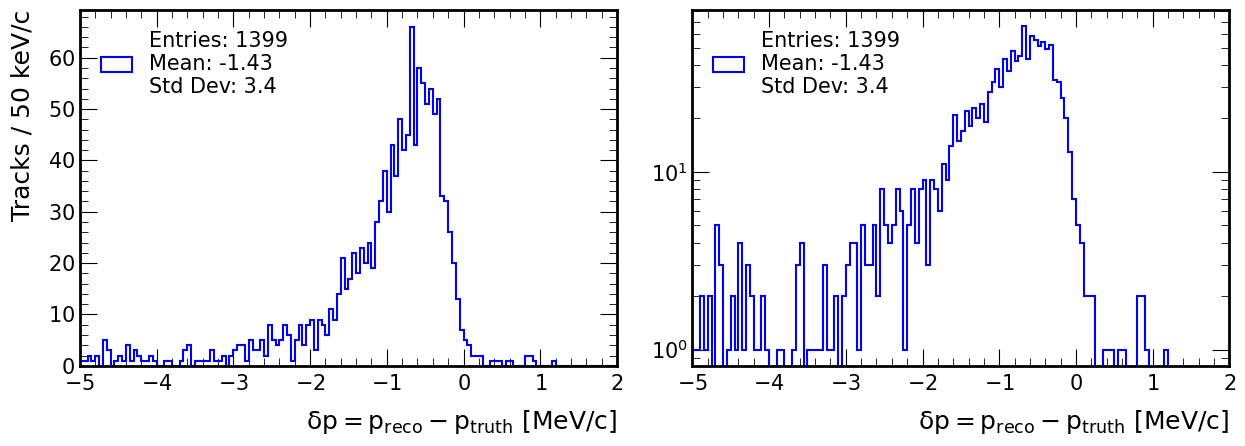

Wrote ../../output/images/misc/h1_1x2_mom_res_au_single.png


In [248]:
import matplotlib.pyplot as plt 
from pyutils.pyplot import Plot
plotter = Plot() 
fig, ax = plt.subplots(1, 2, figsize=(2*6.4, 4.8))
plotter.plot_1D(results, nbins=140, xmin=-5, xmax=2, col="blue", log_y=False, xlabel=r"$\delta p = p_{\text{reco}} - p_{\text{truth}}$ [MeV/c]", ylabel = "Tracks / 50 keV/c", ax=ax[0], show=False)
plotter.plot_1D(results, nbins=140, xmin=-5, xmax=2, col="blue", log_y=True, xlabel=r"$\delta p = p_{\text{reco}} - p_{\text{truth}}$ [MeV/c]", ax=ax[1], show=False)
plt.tight_layout()
out_path="../../output/images/misc/h1_1x2_mom_res_au_single.png"
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Wrote {out_path}")

In [247]:
# !mkdir ../../output/images/dev

/bin/bash: mamba: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `mamba'
/bin/bash: conda: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `conda'
/bin/bash: pip: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `pip'
/bin/bash: setup_mu2e_python_env: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `setup_mu2e_python_env'
/bin/bash: python: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `python'
/bin/bash: jupyter: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `jupyter'
/bin/bash: smack: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `smack'
/bin/bash: _spack_shell_wrapper: line 1: syntax error: unexpected end of file
/bin/bash: error importing functio